In [276]:
# NI-DAQmx Python Documentation: https://nidaqmx-python.readthedocs.io/en/latest/index.html
# NI USB-621x User Manual: https://www.ni.com/docs/en-US/bundle/usb-621x-manual/resource/usb-621x-manual.pdf
import matplotlib.pyplot as plt
import numpy as np
import nidaqmx
import math
import time
import pandas as pd
import os
import datetime

In [ ]:
"""
import ctypes
try:
    nidaq = ctypes.windll.nicaiu
except:
    raise Exception("No se pudo abrir la libreria DAQmx")
"""

'\nimport ctypes\ntry:\n    nidaq = ctypes.windll.nicaiu\nexcept:\n    raise Exception("No se pudo abrir la libreria DAQmx")\n\n'

In [278]:
#para saber el ID de la placa conectada (DevX)
system = nidaqmx.system.System.local()
for device in system.devices:
    print(device)



Device(name=Dev2)


In [279]:
#para setear (y preguntar) el modo y rango de un canal analógico
modoRSE= nidaqmx.constants.TerminalConfiguration.RSE # puede ser DIFF o DIFFERENTIAL 
modoDIFF= nidaqmx.constants.TerminalConfiguration.DIFF # puede ser DIFF o DIFFERENTIAL

with nidaqmx.Task() as task:
    ai_channel = task.ai_channels.add_ai_voltage_chan("Dev2/ai1",max_val=10,min_val=-10,terminal_config= modoRSE )
    print(ai_channel.ai_term_cfg)    # puede ser DIFF o DIFFERENTIAL
    print(ai_channel.ai_max)
    print(ai_channel.ai_min)	

TerminalConfiguration.RSE
10.0
-10.0


In [280]:
with nidaqmx.Task() as task:
    ai_channel = task.ai_channels.add_ai_voltage_chan("Dev2/ai1",max_val=10,min_val=-10)
    print(ai_channel.ai_term_cfg)
    print(ai_channel.ai_max)
    print(ai_channel.ai_min)

TerminalConfiguration.DIFF
10.0
-10.0


In [290]:

## Medicion continua
def medicion_continua(duracion, fs):
    cant_puntos = int(duracion*fs)
    with nidaqmx.Task() as task:
        modoRSE= nidaqmx.constants.TerminalConfiguration.RSE # puede ser DIFF o DIFFERENTIAL 
        modoDIFF= nidaqmx.constants.TerminalConfiguration.DIFF # puede ser DIFF o DIFFERENTIAL 
        task.ai_channels.add_ai_voltage_chan("Dev2/ai1", terminal_config =  modoDIFF)
        task.ai_channels.add_ai_voltage_chan("Dev2/ai2", terminal_config =  modoDIFF)
        task.ai_channels.add_ai_voltage_chan("Dev2/ai4", terminal_config =  modoDIFF)
        task.ai_channels.add_ai_voltage_chan("Dev2/ai5", terminal_config =  modoRSE)
        task.timing.cfg_samp_clk_timing(fs, sample_mode = nidaqmx.constants.AcquisitionType.CONTINUOUS)
        task.start()
        t0 = time.time()
        total = 0
        data =[[],[],[],[],[]]
        Time = []
        while total<cant_puntos:
            time.sleep(0.08)
            datos = task.read(number_of_samples_per_channel=nidaqmx.constants.READ_ALL_AVAILABLE)           
            data[0].append(datos[0])
            data[1].append(datos[1])
            data[2].append(datos[2])
            data[3].append(datos[3])
            total = total + len(datos[0])
            t1 = time.time()
        data[4] = np.linspace(0,t1-t0,len(data[0]))
        return data
    
def medicion_una_vez(duracion, fs):
    cant_puntos = int(duracion*fs)
    with nidaqmx.Task() as task:
        modoRSE= nidaqmx.constants.TerminalConfiguration.RSE # puede ser DIFF o DIFFERENTIAL 
        modoDIFF= nidaqmx.constants.TerminalConfiguration.DIFF # puede ser DIFF o DIFFERENTIAL 
        task.ai_channels.add_ai_voltage_chan("Dev2/ai1", terminal_config =  modoDIFF)
        task.ai_channels.add_ai_voltage_chan("Dev2/ai2", terminal_config =  modoDIFF)
        task.ai_channels.add_ai_voltage_chan("Dev2/ai4", terminal_config =  modoDIFF)
        task.ai_channels.add_ai_voltage_chan("Dev2/ai5", terminal_config =  modoRSE)
               
        task.timing.cfg_samp_clk_timing(fs,samps_per_chan = cant_puntos,
                                        sample_mode = nidaqmx.constants.AcquisitionType.FINITE)
        
        datos = task.read(number_of_samples_per_channel=nidaqmx.constants.READ_ALL_AVAILABLE, timeout=duracion+0.1)           
    datos = np.asarray(datos)    
    return datos

fs = 40000 #Frecuencia de muestreo
duracion = 300 #segundos
data = medicion_continua(duracion, fs)


# plt.plot(data[2], data[3])

df = pd.DataFrame(data)
df = df.T
df.columns = ["B","H","V_platino","V_R","Time"]


df.to_csv(f'datos_array{datetime.datetime.fromtimestamp(time.time()).strftime("%d_%H_%M_%S")}.csv', index=False)
df

,B,H,V_platino,V_R,Time
0,[],[],[],[],0.0
1,"[0.028149264238230755, 0.029301077544200457, 0...","[0.21754032842264037, 0.2145785212433754, 0.21...","[-0.03404864948953164, -0.03437773895575143, -...","[-0.9072869899351462, -0.8806307674721625, -0....",0.08128
2,"[0.028149264238230755, 0.029630167060799878, 0...","[0.11042165182484694, 0.10762439035236165, 0.1...","[-0.013316012608603031, -0.01249328890198853, ...","[-0.33236816073488135, -0.33138089288820244, -...",0.162561
3,"[0.028149264238230755, 0.028642898511812544, 0...","[-0.007227857141525407, -0.009202394059441149,...","[0.025845637636208646, 0.026010182393057982, 0...","[0.6603308442329918, 0.6604953893458088, 0.642...",0.243841
4,"[0.024035645315305776, 0.030781980371028292, 0...","[-0.12899095052540066, -0.1311300316105261, -0...","[0.030123801336206124, 0.028642898511812544, 0...","[0.764487924658207, 0.7918024278724798, 0.7718...",0.325121
...,...,...,...,...,...
3688,"[0.04394556129605482, 0.04427465082478947, 0.0...","[0.018934757909160514, 0.015314773337296667, 0...","[-0.048199496312265666, -0.046554049030816405,...","[-0.8873770953670959, -0.8988952161818337, -0....",299.761758
3689,"[0.034895599363241804, 0.03538923364516054, 0....","[-0.13886363237948324, -0.14297724976079168, -...","[-0.026973225905074685, -0.026973225905074685,...","[-0.5441370859290431, -0.5100763529350751, -0....",299.843038
3690,"[0.02090929496197101, 0.022390197757902013, 0....","[-0.26210759529784217, -0.26474030983404395, -...","[0.027820174722847056, 0.0273265404502775, 0.0...","[0.47636947846051214, 0.5257329800596301, 0.47...",299.924319
3691,"[0.01202387829989264, 0.010542975541709312, 0....","[-0.3453671872526361, -0.3466835443550045, -0....","[0.04921099378887479, 0.046907367064577654, 0....","[0.8207623869310495, 0.8691386911897072, 0.823...",300.005599


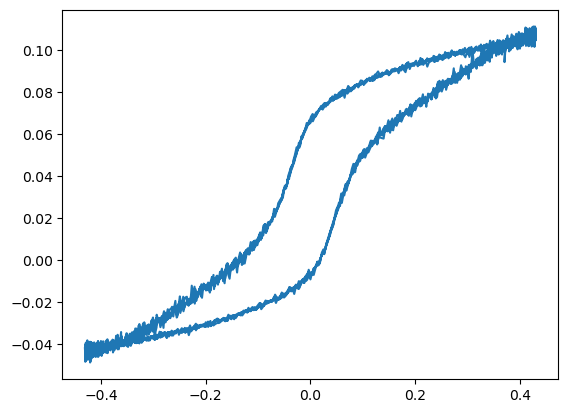

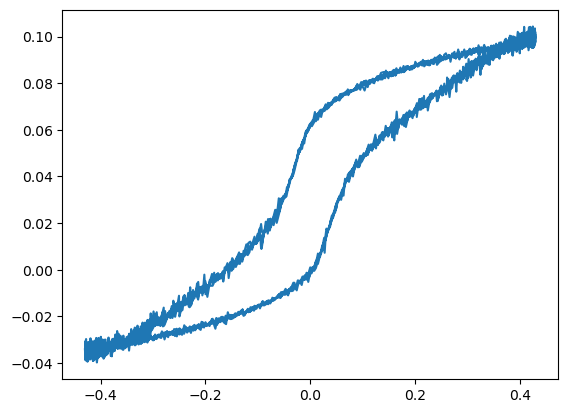

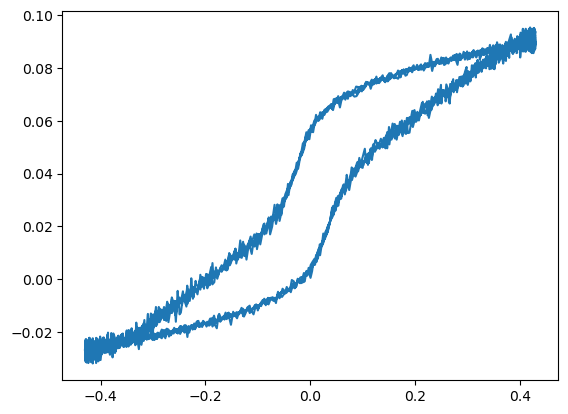

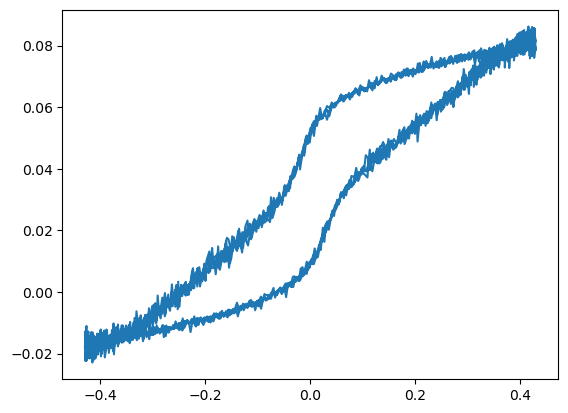

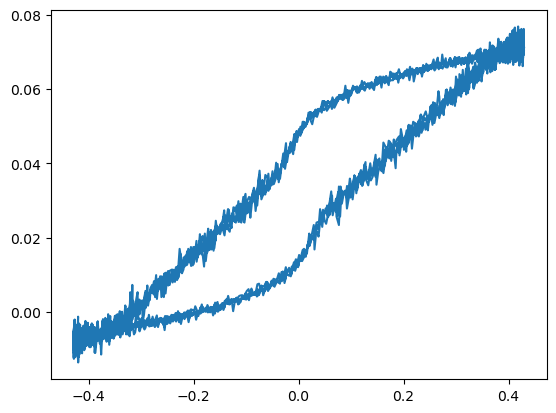

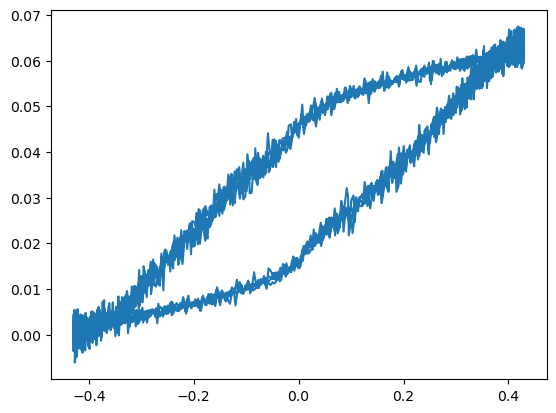

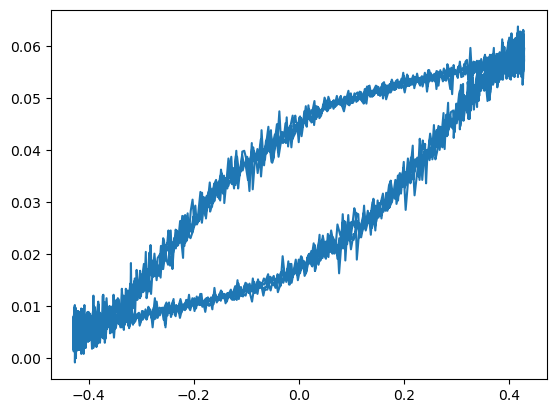

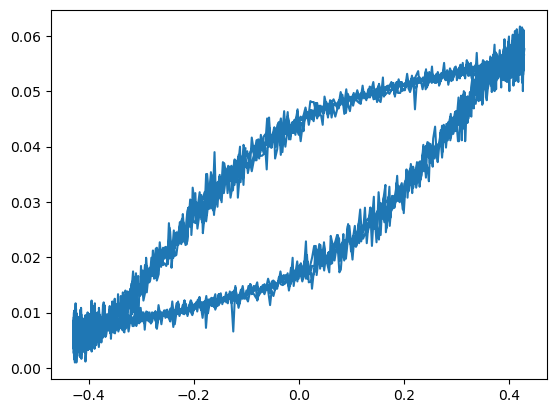

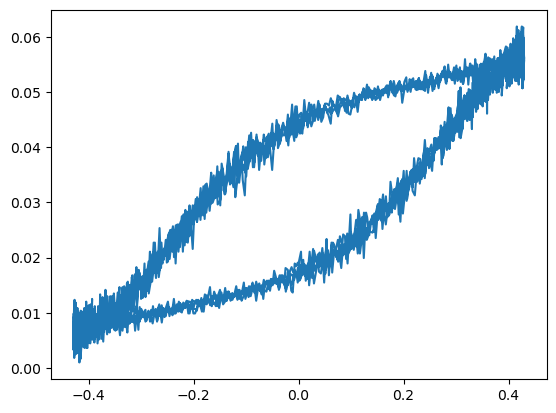

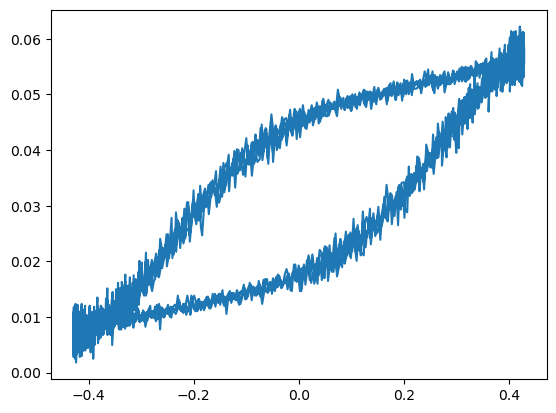

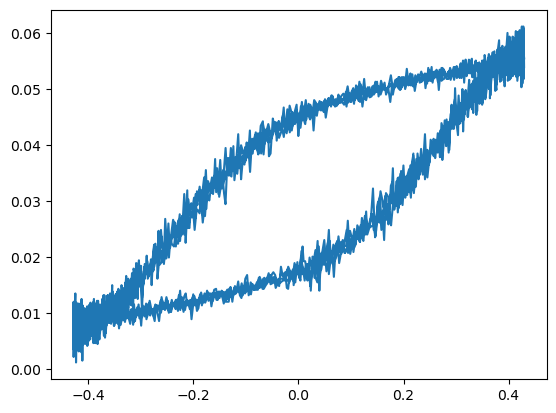

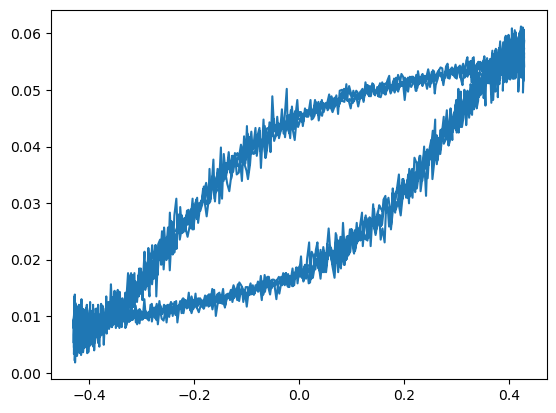

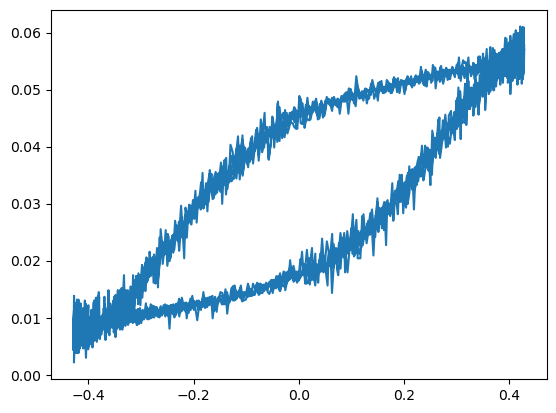

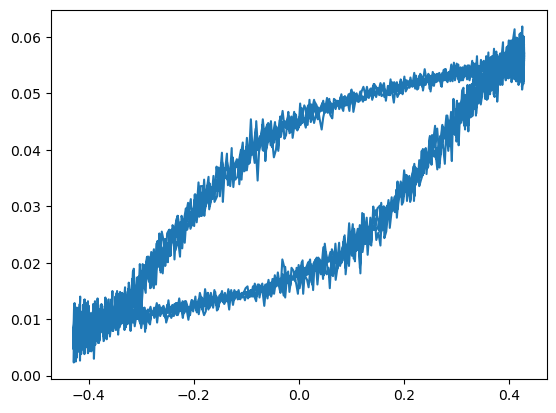

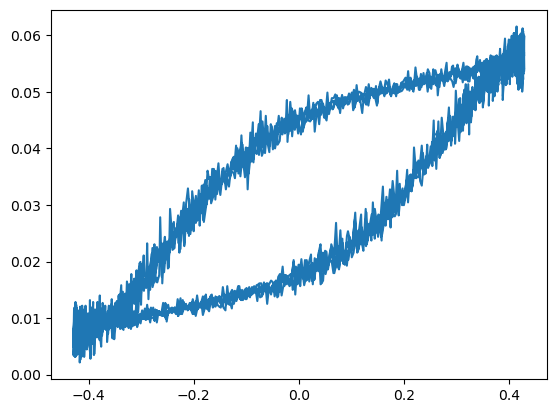

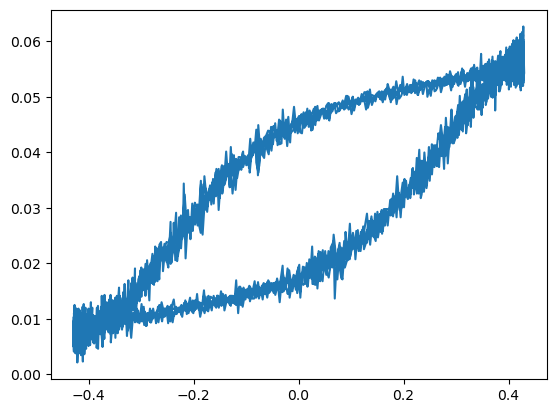

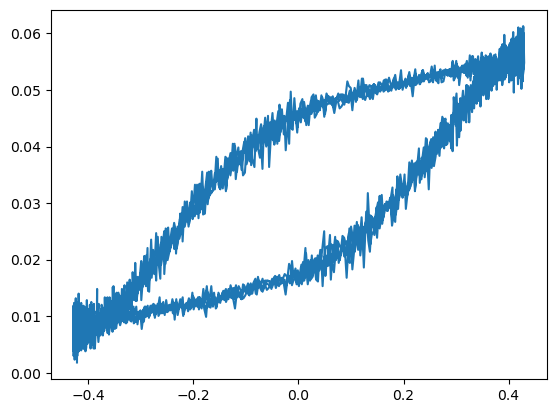

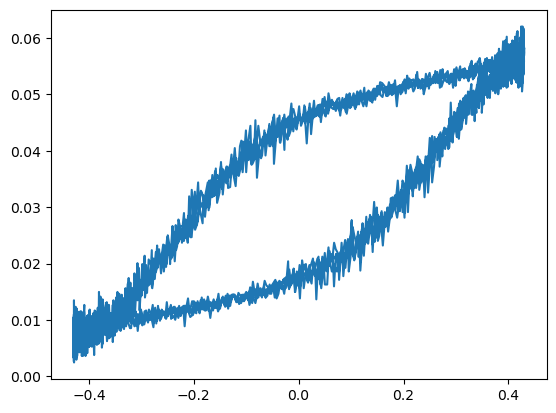

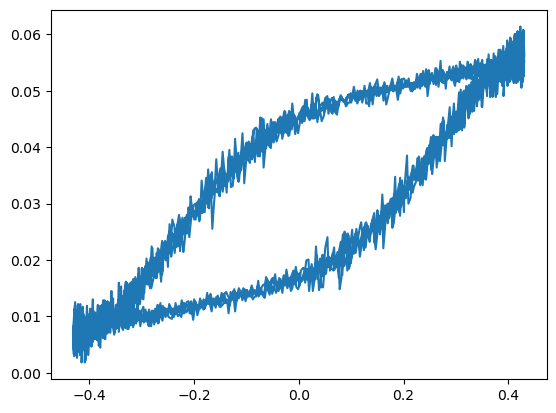

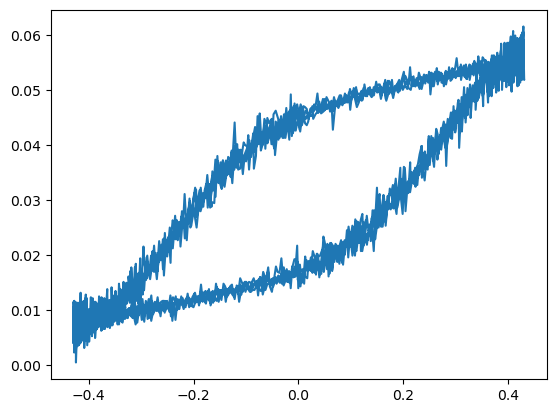

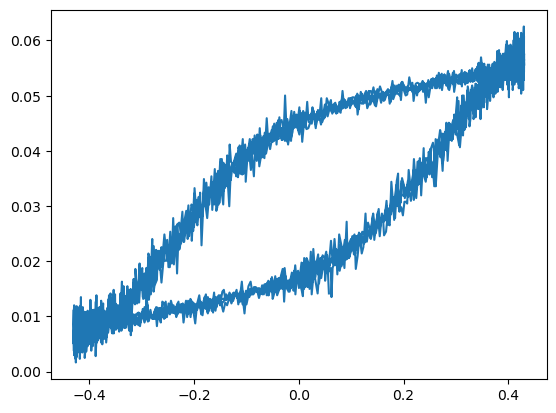

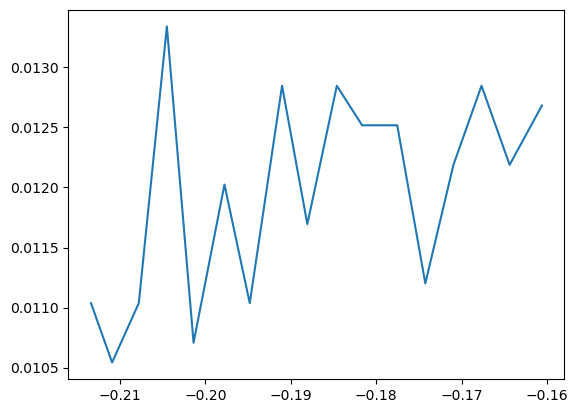

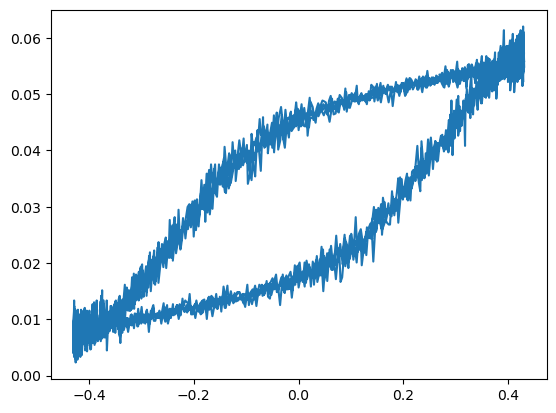

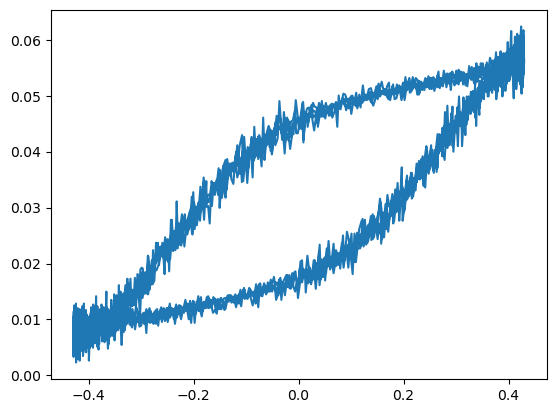

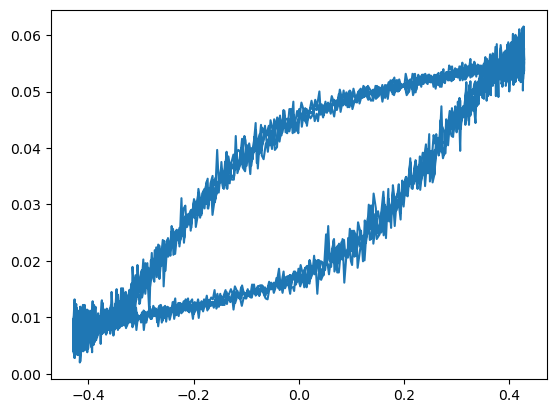

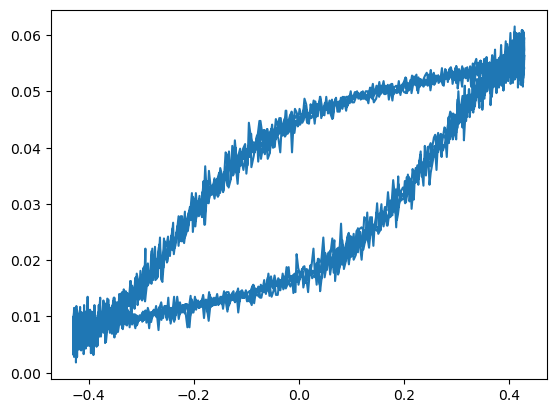

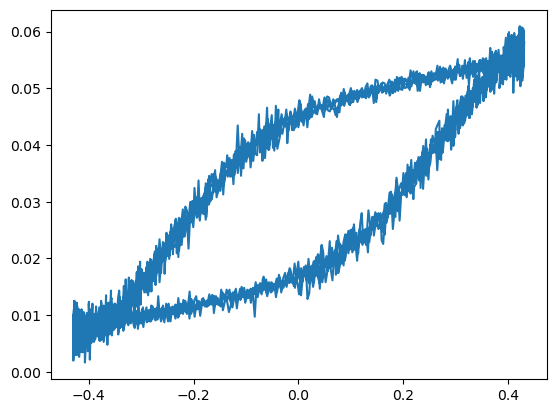

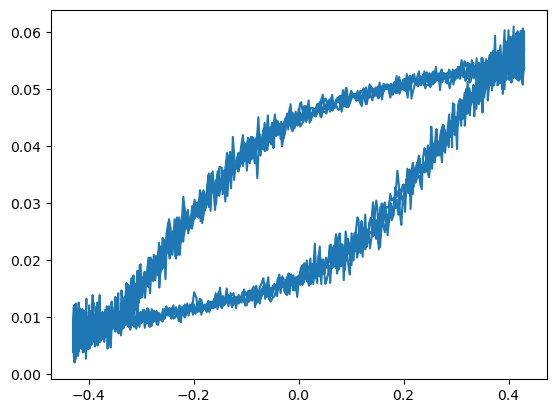

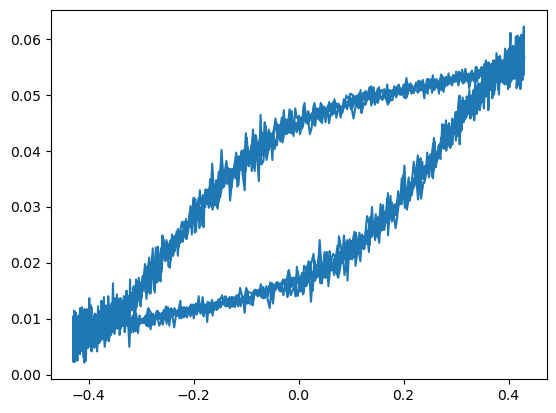

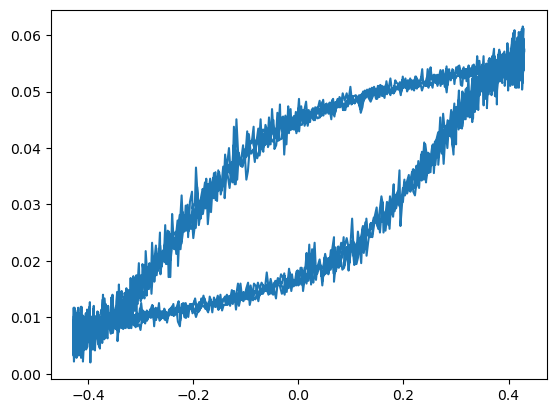

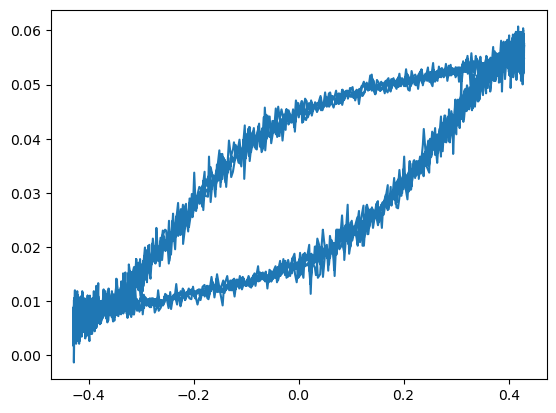

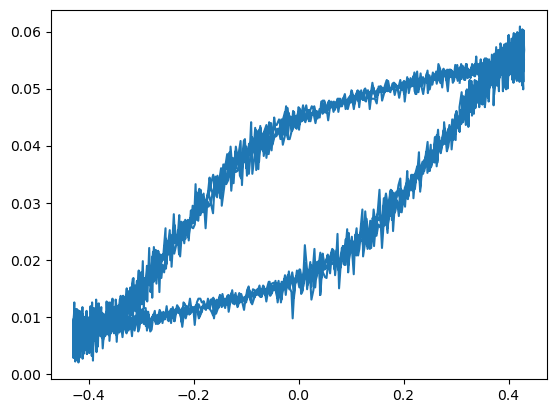

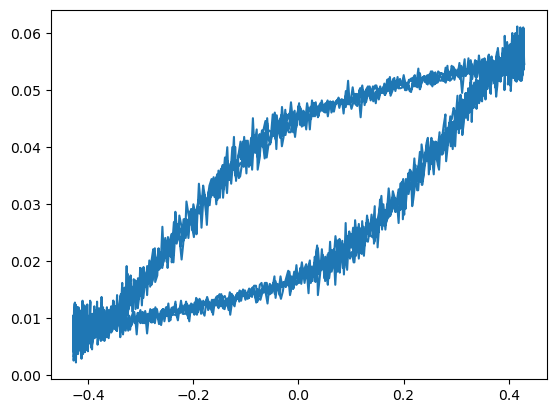

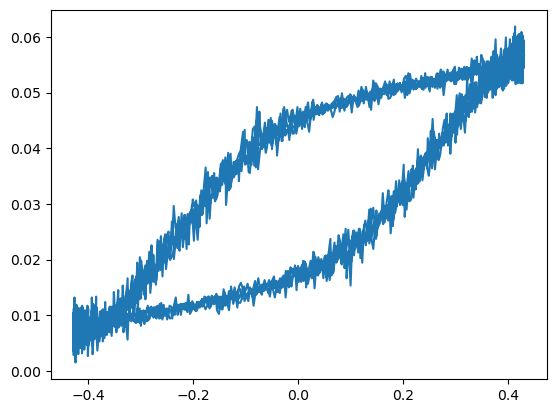

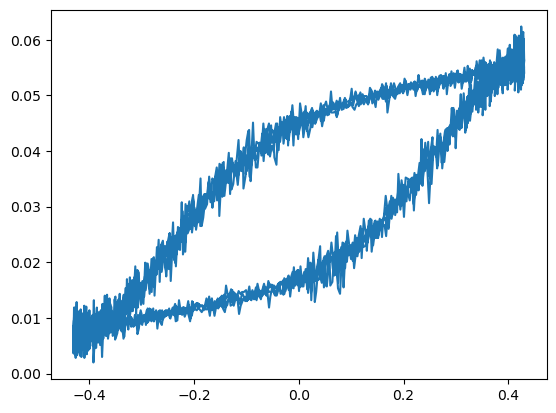

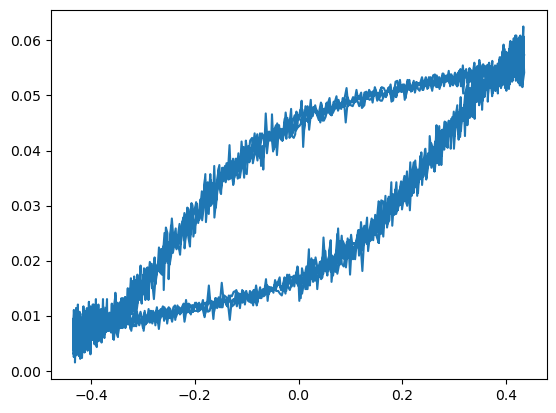

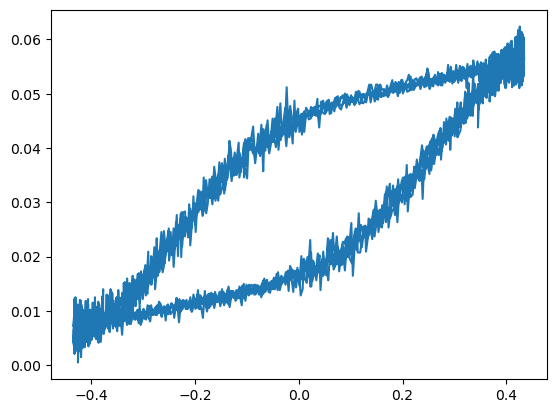

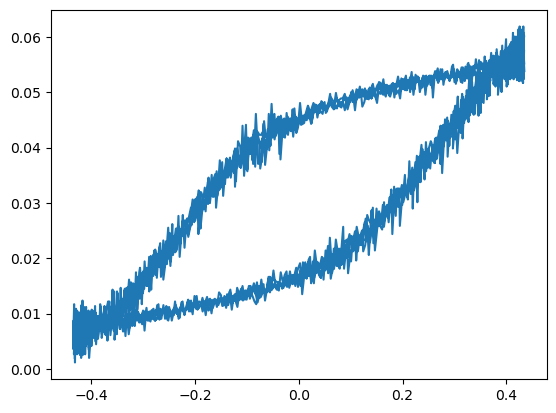

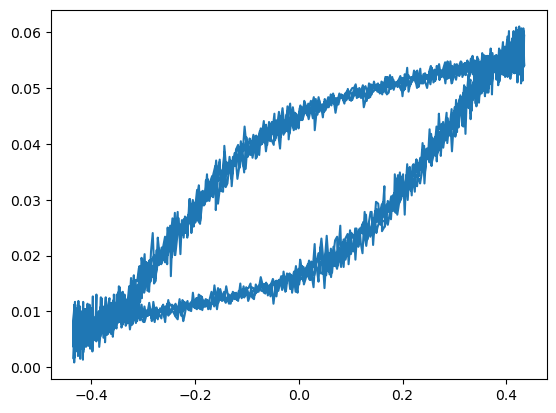

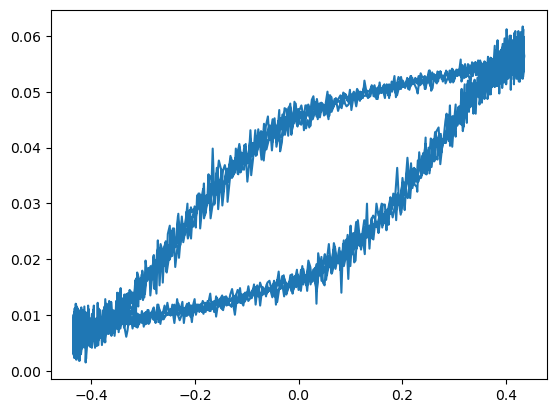

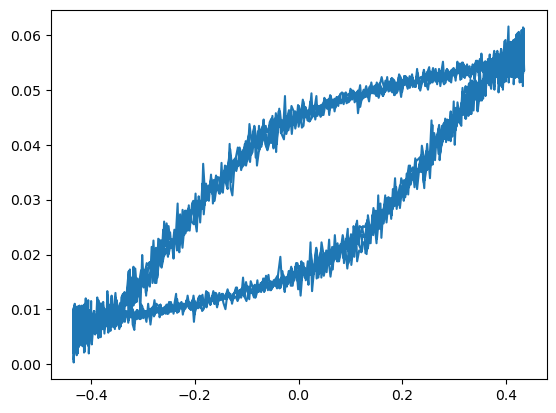

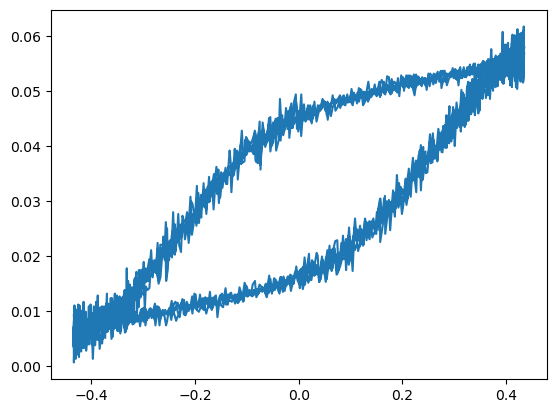

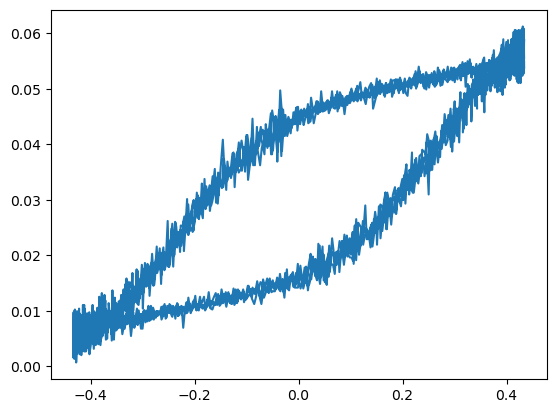

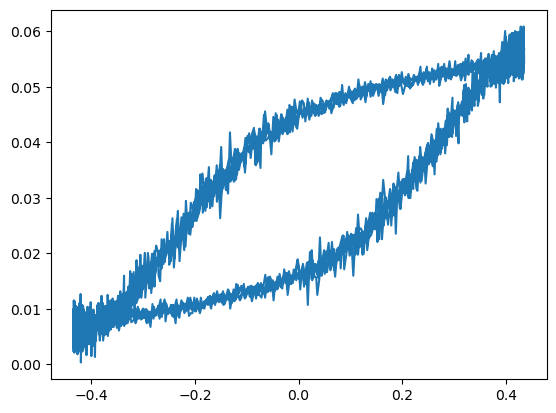

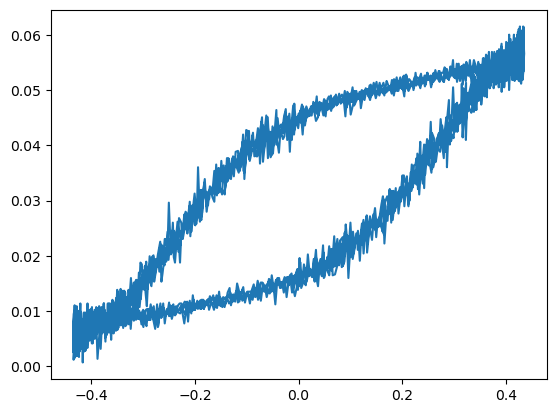

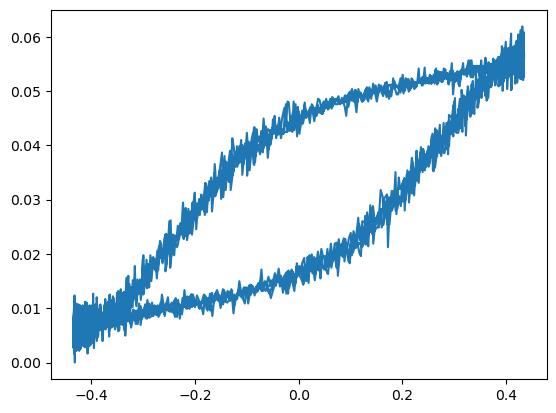

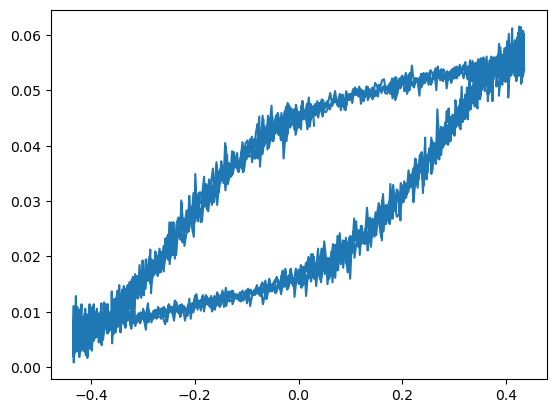

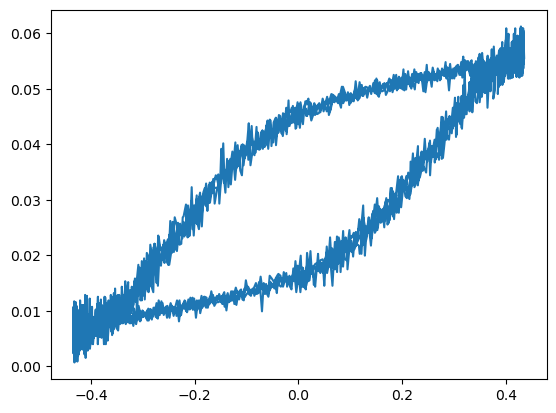

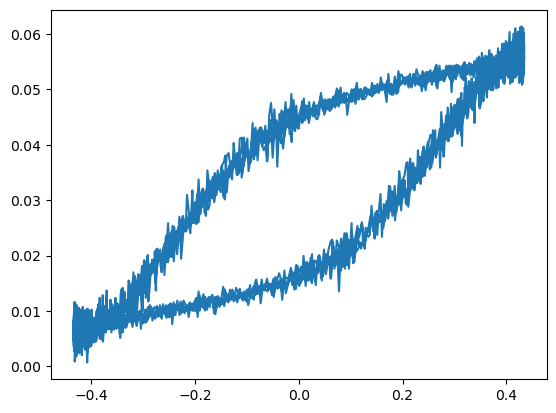

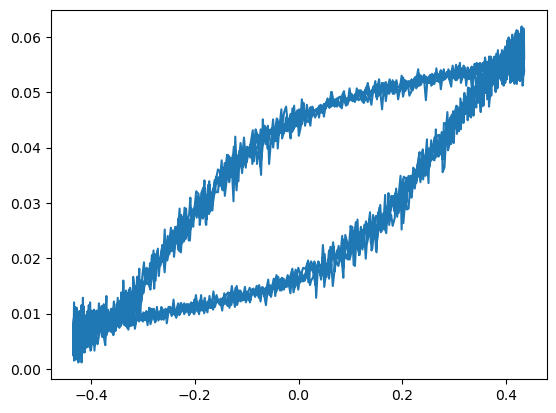

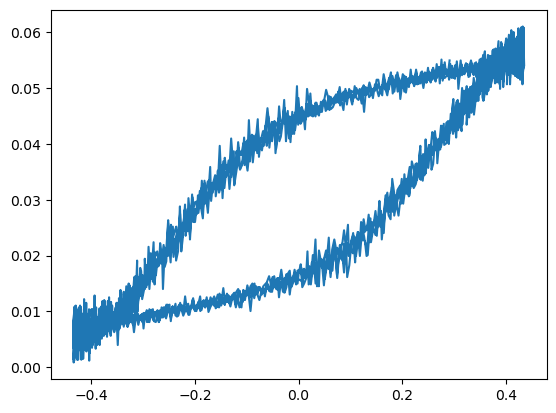

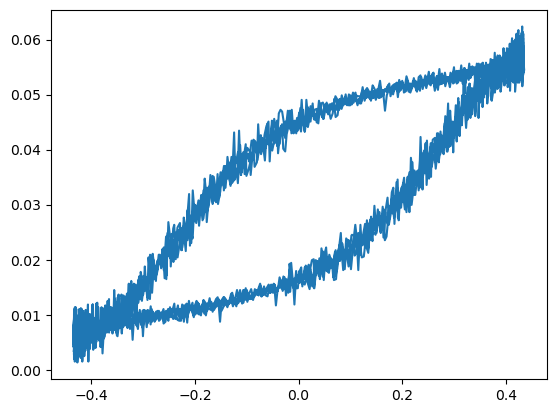

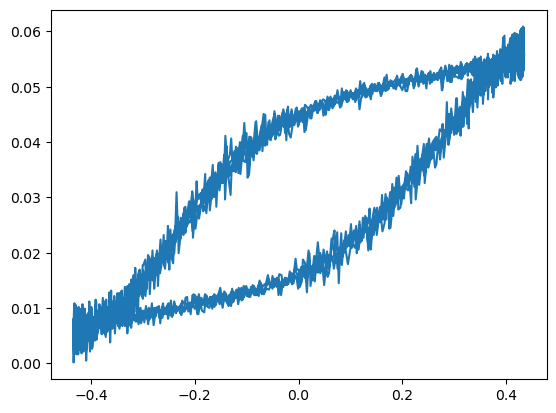

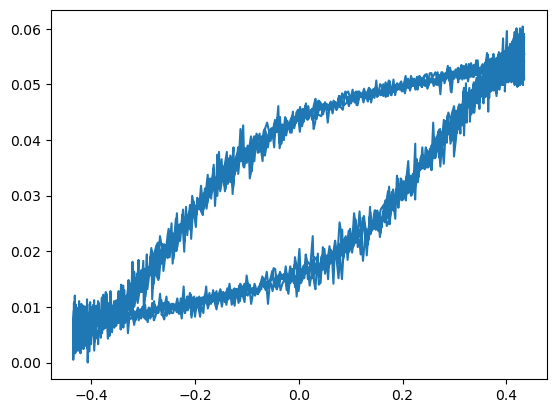

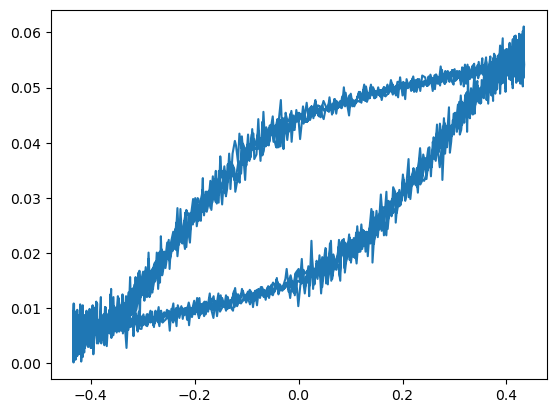

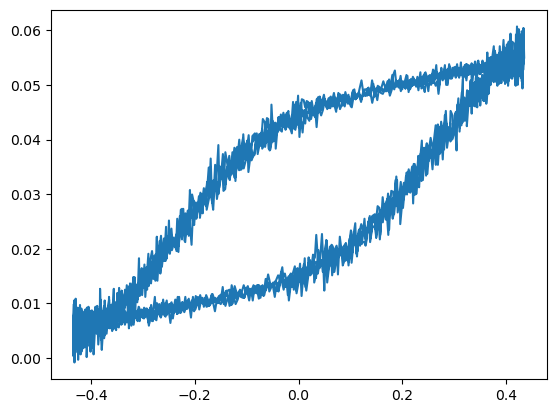

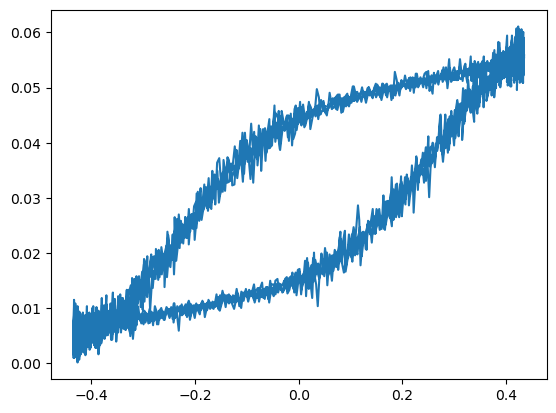

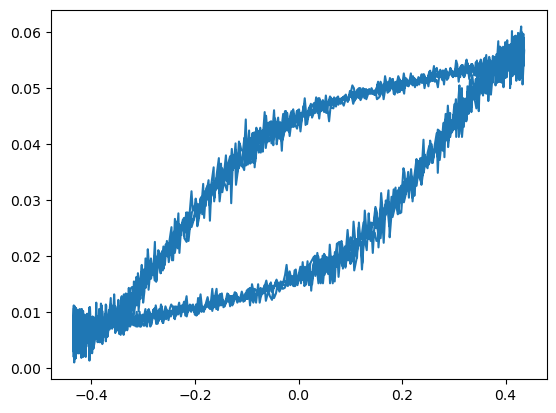

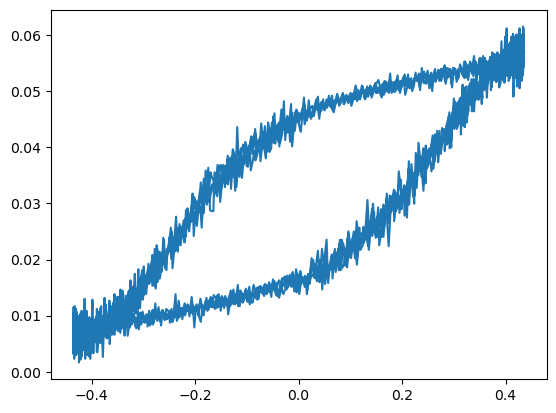

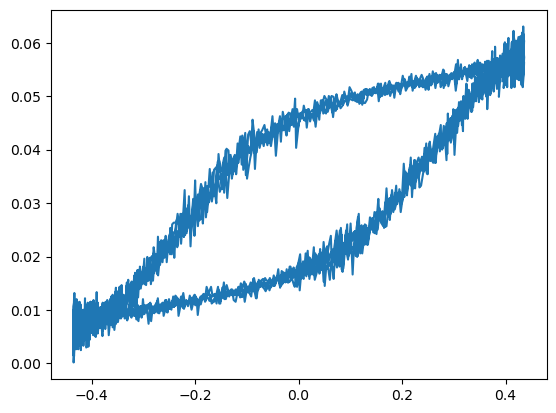

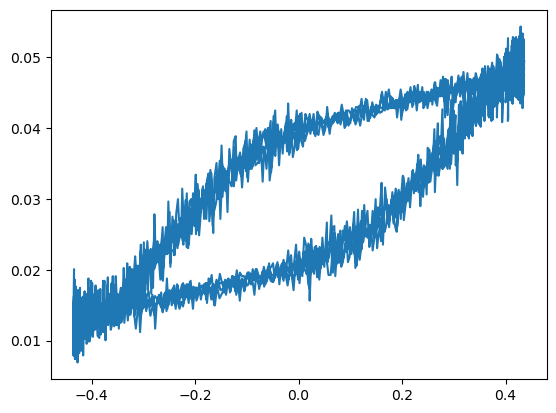

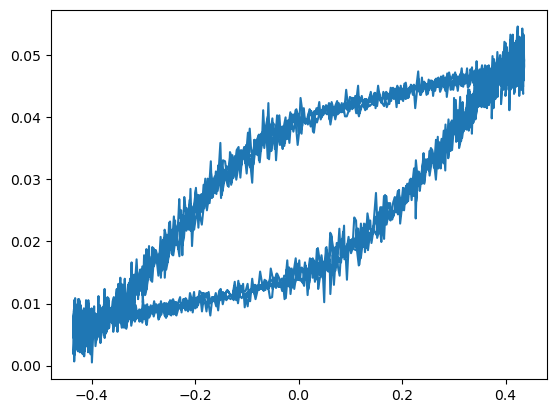

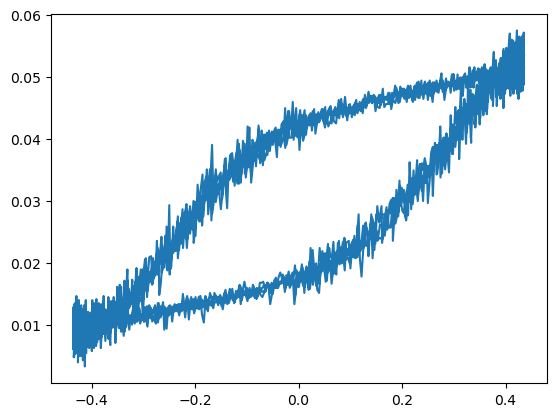

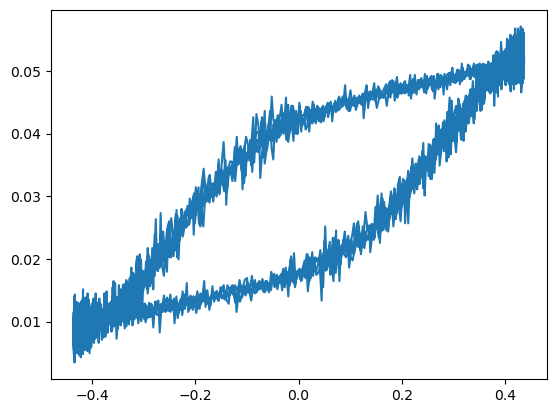

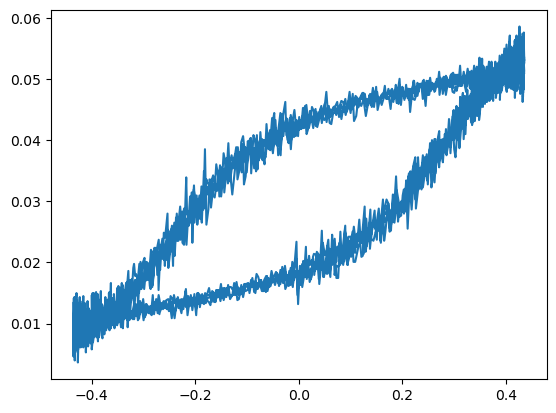

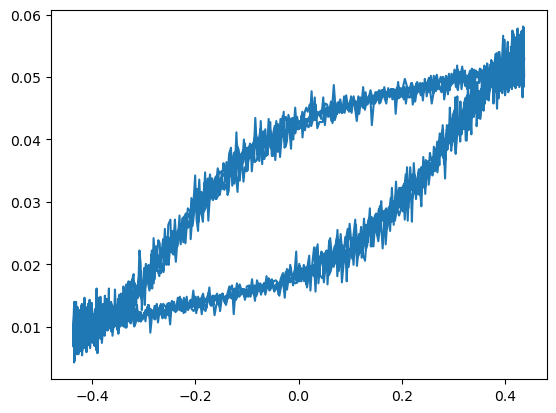

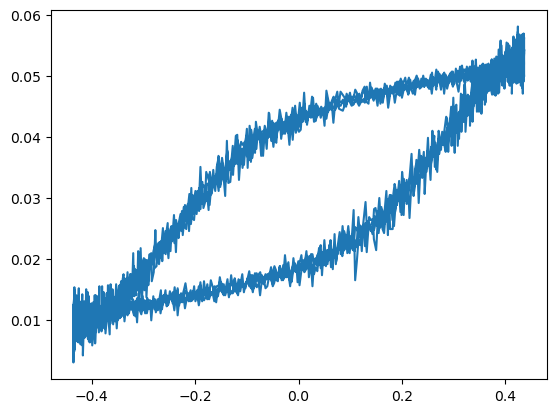

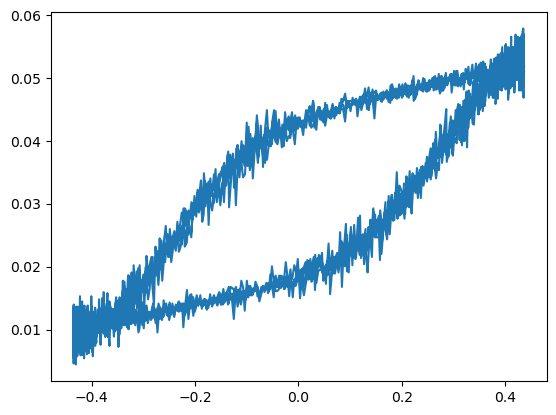

In [304]:
for i in range(200,3600,50):
                   plt.plot(df["H"][i],df["B"][i])
                   plt.show()


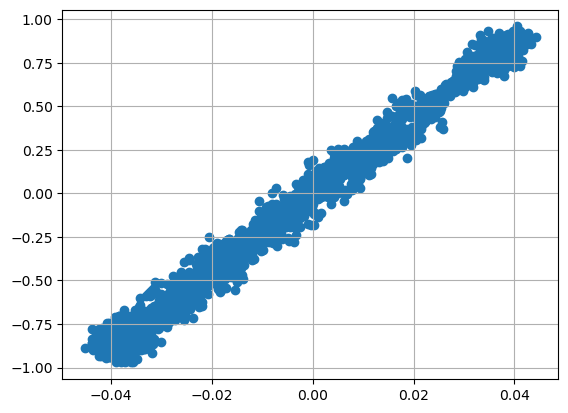

In [298]:
plt.scatter(df["V_platino"][300],df["V_R"][300])
plt.grid()

In [299]:
a = 1
b = -100
def temperatura(res):
    return res * a + b

def temp_kelv(res):
    return res * 0.00385 + 273.23 - 0.385

def resistencia_platino(V_plat, V_R, res=2000):
    return np.abs(V_plat / V_R) * res

In [300]:
v_arr = [[],[]]

for i in range(len(df["V_platino"]) - 1):
    v_arr[0].append((np.std(df["V_platino"][i+1])))
    v_arr[1].append((np.std(df["V_R"][i+1])))




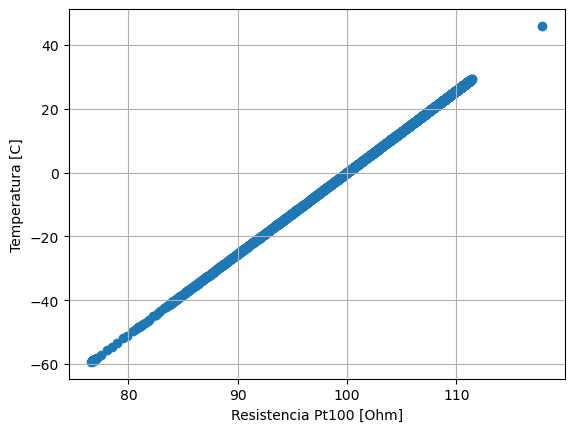

In [301]:
def PT100_res2temp_interp(R): #np.mean
    data = np.loadtxt('Pt100_resistencia_temperatura.csv',delimiter=',') 
    temperature_vals = data[:,0] # en Celsius
    resistance_vals = data[:,1] #en Ohm
    return np.interp(R, resistance_vals, temperature_vals)

R = resistencia_platino(np.array(v_arr[0]),  np.array(v_arr[1]))
plt.scatter(R, PT100_res2temp_interp(R))
plt.ylabel('Temperatura [C]')
plt.xlabel('Resistencia Pt100 [Ohm]')
plt.grid(True)


In [287]:
temperatura(100)

0

In [288]:
temperatura(205)

105

In [289]:


# def daq_conteo(duracion):
#     with nidaqmx.Task() as task:

#         # Configuro la task para edge counting
#         task.ci_channels.add_ci_count_edges_chan(counter=ci_chan1,
#             name_to_assign_to_channel="",
#             edge=nidaqmx.constants.Edge.RISING,
#             initial_count=0)
        
#         # arranco la task
#         task.start()
#         counts = [0]
#         t0 = time.time()
#         try:
#             while time.time() - t0 < duracion:
#                 count = task.ci_channels[0].ci_count
#                 print(f"{time.time()-t0:.2f}s {count-counts[-1]} {count}")
#                 counts.append(count)
#                 time.sleep(0.2)
                
#         except KeyboardInterrupt:
#             pass
        
#         finally:
#             task.stop()
            
#     return counts  

# duracion = 10 # segundos
# y = daq_conteo(duracion)
# plt.plot(y)
# plt.grid()
# plt.show()

# ## Medición con trigger
# # Pinout: 
# # NiUSB6210 
# # PFI0: 1
# # D GND: 5 o 11
# from nidaqmx.constants import AcquisitionType, Edge

# def medicion__una_vez_con_trigger(duracion, fs):
#     cant_puntos = int(duracion*fs)
#     with nidaqmx.Task() as task:
#         # Canal analógico a medir
#         modo= nidaqmx.constants.TerminalConfiguration.DIFFERENTIAL # puede ser DIFF o DIFFERENTIAL PREGUNTAR
#         task.ai_channels.add_ai_voltage_chan("Dev1/ai1", terminal_config = modo)
   
#         # Configuración de muestreo
#         task.timing.cfg_samp_clk_timing(rate=fs, sample_mode=AcquisitionType.FINITE, samps_per_chan=cant_puntos)
   
#         # Configurar trigger digital
#         task.triggers.start_trigger.cfg_dig_edge_start_trig(trigger_source="/Dev1/PFI0", trigger_edge=Edge.RISING)
   
#         task.start()
#         datos = task.read(number_of_samples_per_channel=cant_puntos)
#     datos = np.asarray(datos)
#     return datos

# duracion = 1 #segundos
# fs = 250000 #Frecuencia de muestreo
# y = medicion__una_vez_con_trigger(duracion, fs)
# plt.plot(y)
# plt.grid()
# plt.show()